In [1]:
#importing libraries and reading file
import pandas as pd
import numpy as np
df=pd.read_csv(r"C:\Users\HP Laptops\Downloads\Uber Request Data.csv")

# Uber Demand Supply Analysis

### Introduction to the Dataset

This dataset that we are dealing with has the data related to demand and supply of cabs by Uber. Uber Technologies, Inc. is an American multinational transportation network company offering services that include peer-to-peer ridesharing, ride service hailing, food delivery, and a bicycle-sharing system. The company is based in San Francisco and has operations in 785 metropolitan areas worldwide.

One thing to note over here is that the dataset contains the data for the trips **from** and **to** the **city** and **airport** only.

### A General Overview of the Dataset

In [2]:
#a look at first 5 rows of the dataset
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [3]:
#to know the dimensions of the dataset
df.shape

(6745, 6)

So, as we can see, the dataset has the following columns:

1. Request id: The unique identification number given to the customer at the time he/she books a cab.

2. Pickup point: The location from where the person had been picked up for the ride (we have only 'Airport' and 'City' as    locations over here.)

3. Driver id: Unique identification number for the driver.

4. Status: This column indicates the status of the trip i.e whether it was completed,cancelled etc.

5. Request timestamp: The date and time at which the cab was requested for.

6. Drop timestamp: The date and time at which the person was dropped to the destination.

There are a total of 6745 rows and 6 columns.

### Cleaning the data

 First, let's change the Request timestamp and Drop timestamp to the correct timeseries format.

In [4]:
#Modifying the column timeseries values to correct format
df['Request timestamp'] = pd.to_datetime(df['Request timestamp'])
df['Drop timestamp'] = pd.to_datetime(df['Drop timestamp'])
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


 As we have resolved the issue of date and time format, let's move on to check what else do we have with us.

Now, lets check for the null values in our dataset....

In [5]:
#a check for null values
df.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

We notice that all other columns have no null values except for the Driver id and Drop timestamp.

In [6]:
#having a look at last 5 rows of column Driver id and Drop timestamp
df[['Driver id','Drop timestamp']].tail()

,Driver id,Drop timestamp
6740,NaN,NaT
6741,NaN,NaT
6742,NaN,NaT
6743,NaN,NaT
6744,NaN,NaT


In [7]:
#To know total no. of entries having NaN values
df[(df['Drop timestamp'].isnull())].groupby('Status').size()

Status
Cancelled            1264
No Cars Available    2650
dtype: int64

That makes a total of 3914, the exact number of null values in the Drop timestamp. The Driver id and the Drop timestamp have null values for the requets that can not be served due to non availibililty of the cabs, so, it's important to keep the null values as they would tell us when Uber couldn't serve the request of a customer due to shortage in no. of cabs.

Also, we should drop the column Driver id, as our main concern is to find how many times was the request made by customers served or not, and not how many requests were served by a single driver. So, let's proceed with this....

In [8]:
#dropping the Driver id colummn
df1=df.drop('Driver id',axis=1)
df1.head()

,Request id,Pickup point,Status,Request timestamp,Drop timestamp
0,619,Airport,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00
1,867,Airport,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00
2,1807,City,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00
4,3112,City,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


Also, let's see what all values do we have in the status column....

In [9]:
#to know what unique values are present in the Status column
pd.unique(df1['Status'])

array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

The values with us in the status column are Trip Completed, Cancelled and No Cars Available. 
We already know the data provided to us has entries for trips only from and to the airport and the city, but for sake of confirmation, let's have a check on the values of Pickup point column....

In [10]:
#to know the unique values present in Pickup point column
pd.unique(df1['Pickup point'])

array(['Airport', 'City'], dtype=object)

### Deriving New Columns

There are certain things that we can derive from our dataset. First of all, we should extract the hour from the Request timestamp column so that we can see at what time of the day, a cab was requested, whether the ride was cancelled, completed, or the cab wasn't available. So, lets do it....

In [11]:
#deriving Request hour - extracting hour from the given date time
df1['Request hour'] = df1['Request timestamp'].dt.hour

In [12]:
#deriving time of the day and assigning values according to the request hour
df1['Time of the day'] = 'Early Morning(12:00AM to 4:59AM)'
df1.loc[df1['Request hour'].between(5,9, inclusive=True),'Time of the day'] = 'Morning(5:00AM to 8:59AM)'
df1.loc[df1['Request hour'].between(9,12, inclusive=True),'Time of the day'] = 'Late Morning(9:00AM to 11:59AM)'
df1.loc[df1['Request hour'].between(12,17, inclusive=True),'Time of the day'] = 'Afternoon(12:00PM to 4:59PM)'
df1.loc[df1['Request hour'].between(17,21, inclusive=True),'Time of the day'] = 'Evening(5:00PM to 8:59PM)'
df1.loc[df1['Request hour'].between(21,24, inclusive=True),'Time of the day'] = 'Night(9:00PM to 11:59PM)'

In [13]:
#looking at first five rows of the dataset
df1.head()

,Request id,Pickup point,Status,Request timestamp,Drop timestamp,Request hour,Time of the day
0,619,Airport,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,11,Late Morning(9:00AM to 11:59AM)
1,867,Airport,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,17,Evening(5:00PM to 8:59PM)
2,1807,City,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,9,Late Morning(9:00AM to 11:59AM)
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,21,Night(9:00PM to 11:59PM)
4,3112,City,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,Morning(5:00AM to 8:59AM)


As seen above, we have succesfully alloted time slots according to the hour in which a cab was requested....
Now let's derive columns **CabDemand** which will have all the values as 1, **CabSupply** where the values where trip is completed is 1 else 0 and **Gap** that will give the difference between CabDemand and CabSupply i.e 0 [CabDemand=1 and CabSupply=1 therefore 1-1=0] if cab was available and trip completed, 0 [CabDemand=1 and CabSupply=0 therefore 1-0=1] if ride was cancelled or no cabs were available....

In [14]:
#deriving columns CabDemand, CabSupply and assigning values to them
df1['CabDemand'] = 1
df1['CabSupply'] = 0
df1.loc[(df1['Status'] == 'Trip Completed'),'CabSupply'] = 1

In [15]:
#deriving column Gap and assigning values to it
df1['Gap'] = df1['CabDemand'] - df1['CabSupply']
df1.loc[df1['Gap']==0,'Gap'] = 'Trip Completed'
df1.loc[df1['Gap']==1,'Gap'] = 'Trip Not Completed'

In [16]:
#first five rows of the dataset
df1.head()

,Request id,Pickup point,Status,Request timestamp,Drop timestamp,Request hour,Time of the day,CabDemand,CabSupply,Gap
0,619,Airport,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,11,Late Morning(9:00AM to 11:59AM),1,1,Trip Completed
1,867,Airport,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,17,Evening(5:00PM to 8:59PM),1,1,Trip Completed
2,1807,City,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,9,Late Morning(9:00AM to 11:59AM),1,1,Trip Completed
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,21,Night(9:00PM to 11:59PM),1,1,Trip Completed
4,3112,City,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,Morning(5:00AM to 8:59AM),1,1,Trip Completed


So, we have finished deriving the required columns....

In [17]:
#importing pyplot and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

Let's move to univariate analysis....

# Univariate Analysis

Let's have a look at what is the distribution of the data....

Let's have a look over distribution of **Pickup point**....

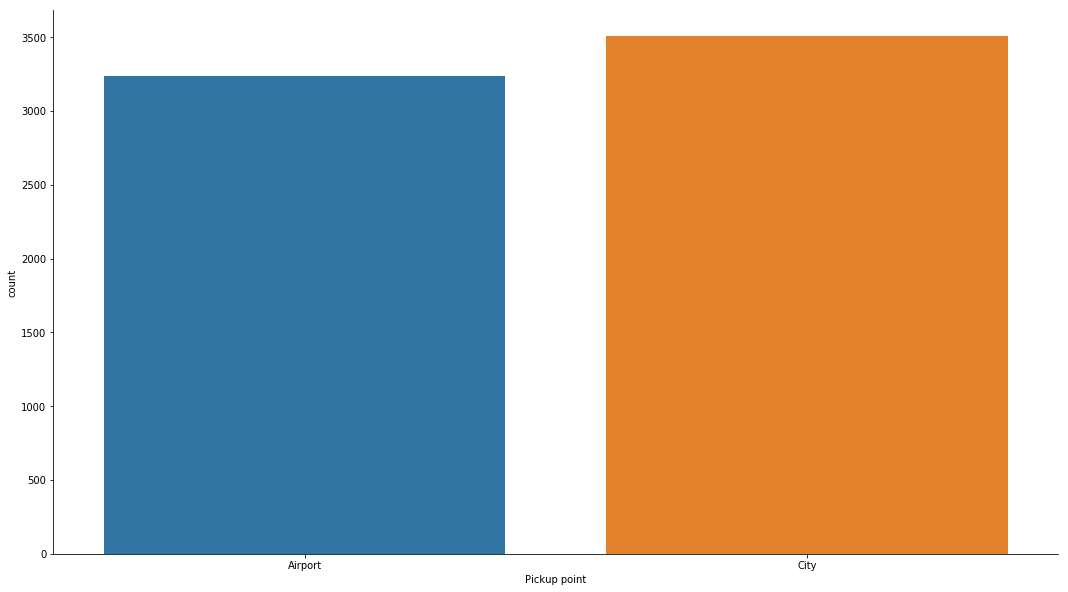

In [18]:
#plot to see the distribution of values in Pickup point
plt.rcParams['figure.figsize']=(18,10)
sns.countplot(data=df1,x='Pickup point')
sns.despine()

In [19]:
#Stats for Pickup point column
df1['Pickup point'].describe()

count     6745
unique       2
top       City
freq      3507
Name: Pickup point, dtype: object

As we see, their were slightly more number of pickups from the city for the airport rather than that from the airport to city.
Lets move on....

Taking **Status** into consideration....

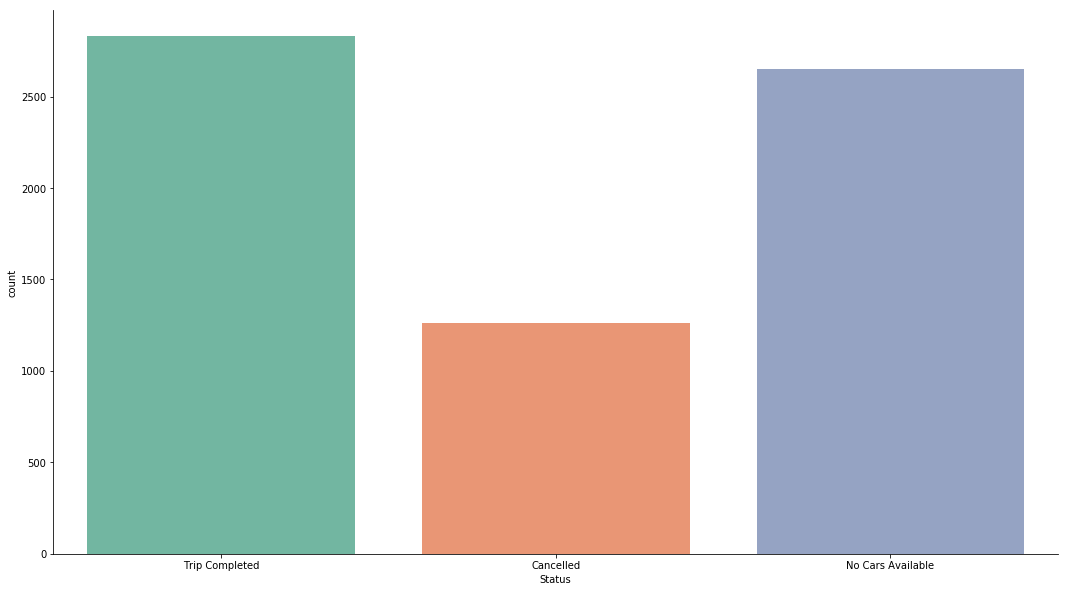

In [20]:
#plot to see the distribution of values in Status
plt.rcParams['figure.figsize']=(18,10)
sns.countplot(data=df1,x='Status',palette='Set2')
sns.despine()

In [21]:
#Stats for Status column
df['Status'].describe()

count               6745
unique                 3
top       Trip Completed
freq                2831
Name: Status, dtype: object

No. of trips completed is slightly more than the no. of times a cab wasn't available. The no. of times a cab was cancelled is somewhere between 1000 and 1500

Let's have a look at how many trips were completed and how many not completed i.e **Gap**....

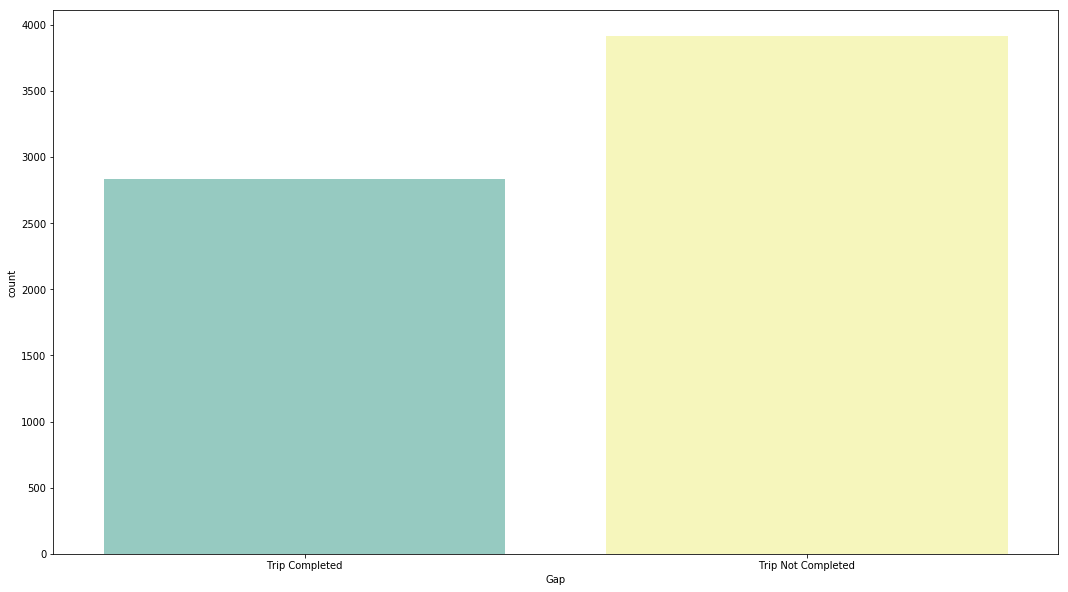

In [22]:
#plot showing distribution of Gap
plt.rcParams['figure.figsize']=(18,10)
sns.countplot(x=df1['Gap'], data = df1,palette='Set3')

In [23]:
#Stats for Gap column
df1['Gap'].describe()

count                   6745
unique                     2
top       Trip Not Completed
freq                    3914
Name: Gap, dtype: object

So far, we are able to get a slight insight from the data. Let's move on to bivariate analysis....

# Bivariate Analysis

We will be now taking two variables into consideration at a time, to see how it really effected the Demand and Supply scenario....

A look at **Status** and **Pickup point** together will give us a good understanding of what went wrong, so....

In [25]:
#import for mosaic plot
from statsmodels.graphics.mosaicplot import mosaic

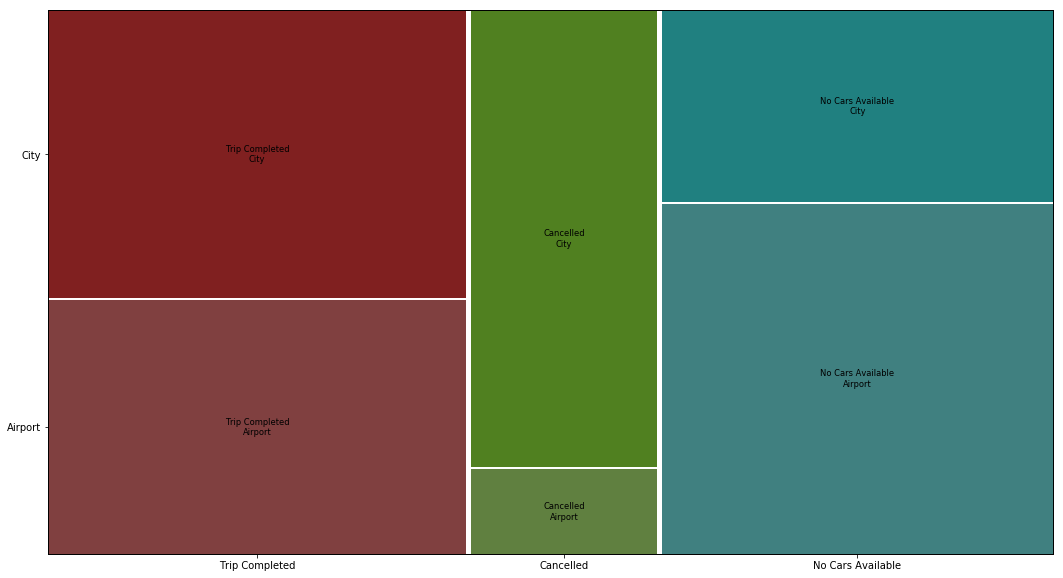

In [26]:
#mosaic plot between Status and Pickup point
plt.rcParams['figure.figsize']=(18,10)
mosaic(df1, ['Status', 'Pickup point'])
plt.show()

In [27]:
#Stats for above graph
df1[['Pickup point','Status']].describe()

,Pickup point,Status
count,6745,6745
unique,2,3
top,City,Trip Completed
freq,3507,2831


As we see, the **Trips completed** from the city and from the airport are almost **same**, while **more** rides were **cancelled** at the city side rather than the airport. Also, number of cabs **not available** for the rides from airport is comparitively **larger** than those not available from the city.

Let's have a look at **individual Status at Pickup points**....  

Let's take **Trips Completed** into consideration....

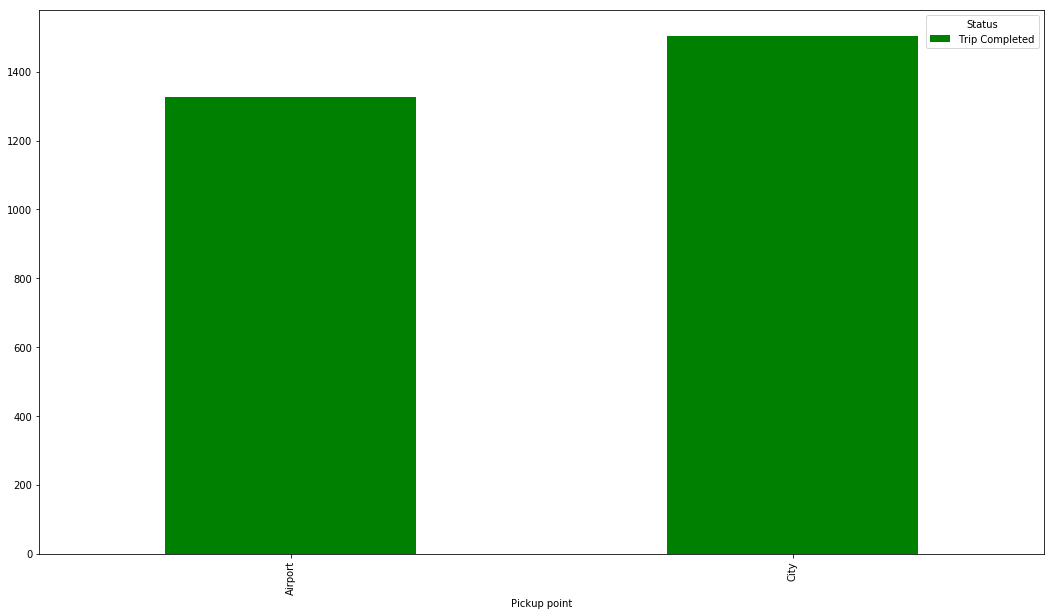

In [29]:
#plot for Trips Completed at city and airport
plt.rcParams['figure.figsize']=(18,10)
pickupgap = pd.DataFrame(df1.loc[(df1['Status']=='Trip Completed')].groupby(['Pickup point','Status'])['Status'].count().unstack(fill_value=0))
pickupgap.plot.bar(color=['green'])

More rides were served at the city rather than at airport.

Looking at **Cancelled** trips at city and airport....

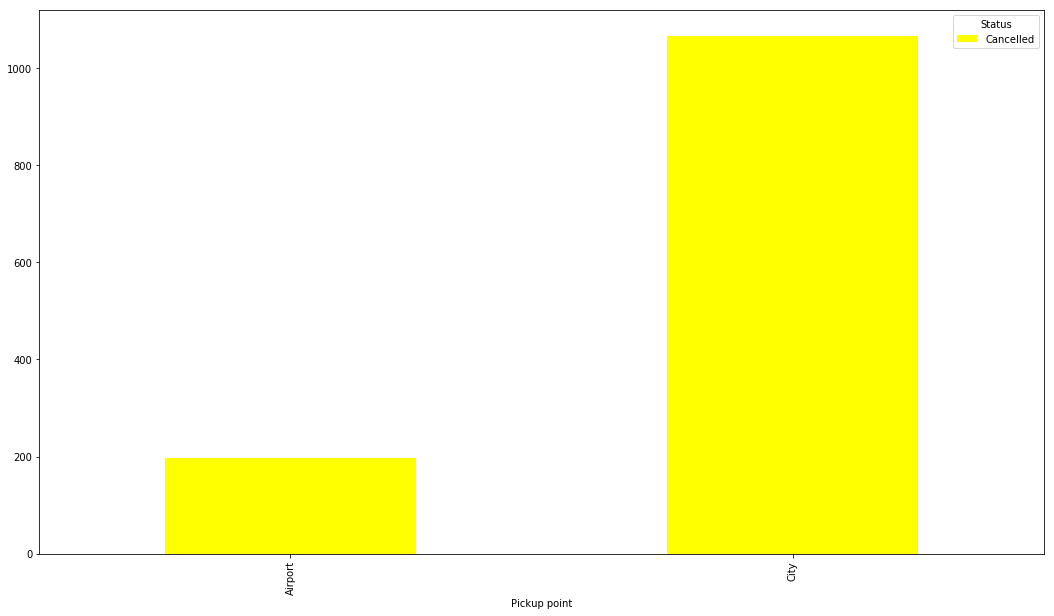

In [30]:
#plot for cancelled rides at city and airport
plt.rcParams['figure.figsize']=(18,10)
pickupgap = pd.DataFrame(df1.loc[(df1['Status']=='Cancelled')].groupby(['Pickup point','Status'])['Status'].count().unstack(fill_value=0))
pickupgap.plot.bar(color=['yellow'])

So most no. of rides were **cancelled at the airport**.

Now let's have a look at how many times **No Cars** were **Available**....

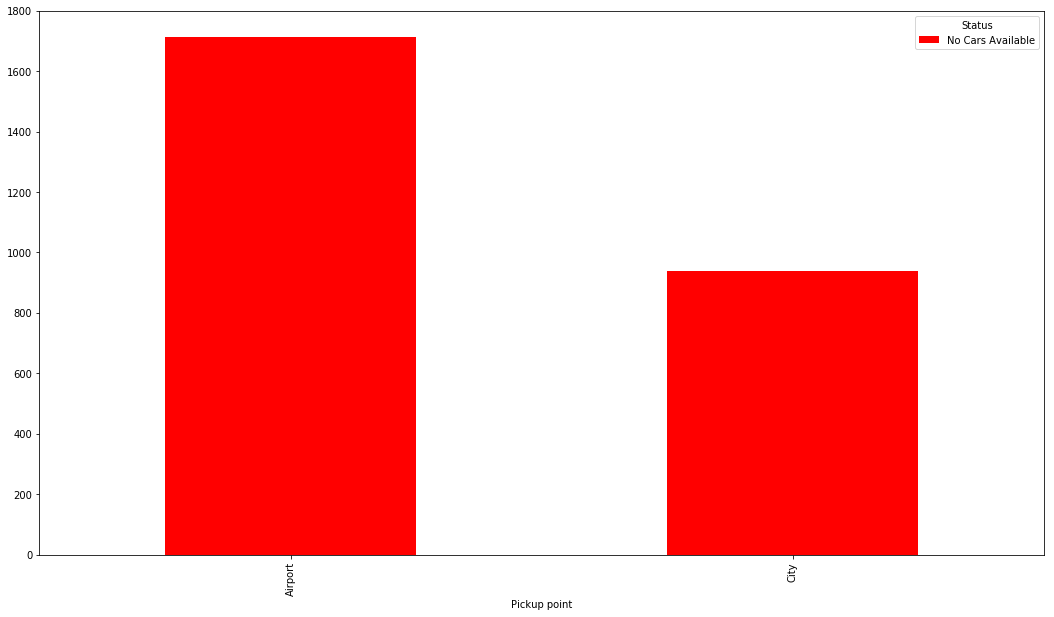

In [31]:
#plot for No Cars Available at city and airport
plt.rcParams['figure.figsize']=(18,10)
pickupgap = pd.DataFrame(df1.loc[(df1['Status']=='No Cars Available')].groupby(['Pickup point','Status'])['Status'].count().unstack(fill_value=0))
pickupgap.plot.bar(color=['red'])

Again, we see more no. of times a cab wasn't avialble at the airport than at the city.

Having a look at  **Time of the day** and **Status**

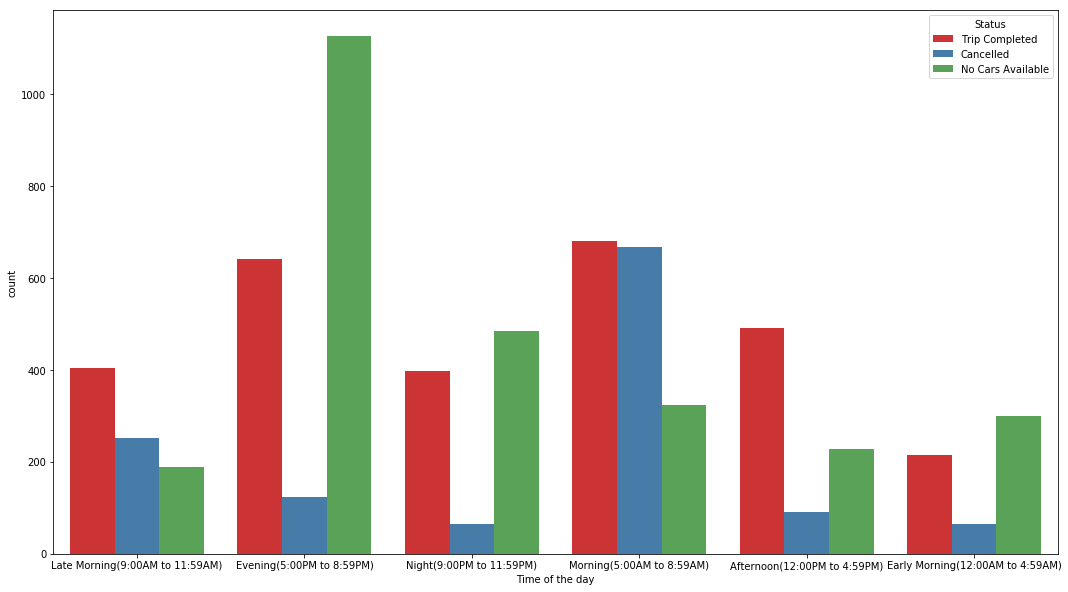

In [30]:
#plot between Time of the day and Status
plt.rcParams['figure.figsize']=(18,10)
sns.countplot(x=df1['Time of the day'],hue =df1['Status'] ,data = df1,palette='Set1')

In [40]:
# Stats for the above graph
df1[['Time of the day','Status']].describe()

,Time of the day,Status
count,6745,6745
unique,6,3
top,Evening(5:00PM to 8:59PM),Trip Completed
freq,1893,2831


We notice the highest no. of times no cabs were available was for the evening i.e 5 PM to 8:59 PM, may be because that is the time of the day when people return to their homes after work

**Pickup point** and **Gap**....

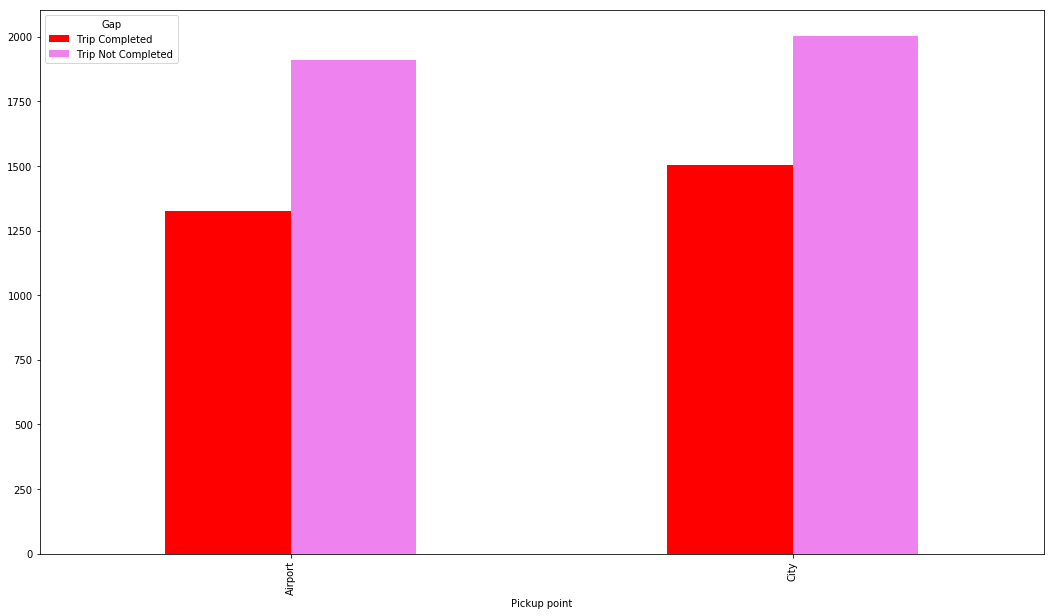

In [32]:
#plot between Pickup point and Gap
plt.rcParams['figure.figsize']=(18,10)
pickupgap = pd.DataFrame(df1.groupby(['Pickup point','Gap'])['Request id'].count().unstack(fill_value=0))
pickupgap.plot.bar(color=['red','violet'])

In [32]:
#Status for the above graph
df1[['Pickup point','Gap']].describe()

,Pickup point,Gap
count,6745,6745
unique,2,2
top,City,Trip Not Completed
freq,3507,3914


For both City and Airport, a higher number of trips were not completed i.e either cancelled or no cabs were available....

Let's have a look at **Time of the day** and **Gap**....

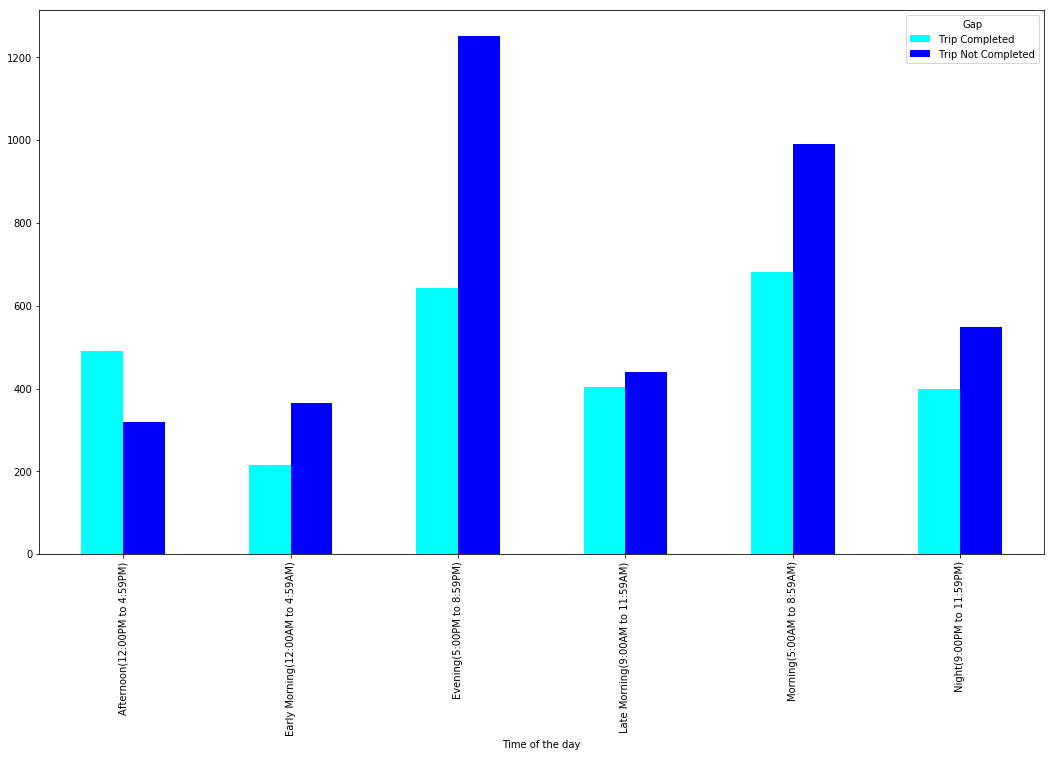

In [34]:
#plot for Time of the day, Gap
plt.rcParams['figure.figsize']=(18,10)
timegap = pd.DataFrame(df1.groupby(['Time of the day','Gap'])['Request id'].count().unstack(fill_value=0))
timegap.plot.bar(color=['cyan','blue'])

In [41]:
#Stats for the above graph
df1[['Time of the day','Gap']].describe()

,Time of the day,Gap
count,6745,6745
unique,6,2
top,Evening(5:00PM to 8:59PM),Trip Not Completed
freq,1893,3914


Again we see that a lot of trips were not completed between the time 5:00 PM to 8:59 PM.

Let's move on to get a deeper insight....

# Multivariate Analysis

We wiil be considering three variable at a time now...

First, let's take **Pickup point**, **Time of the day** and **Status** to see what has happened....

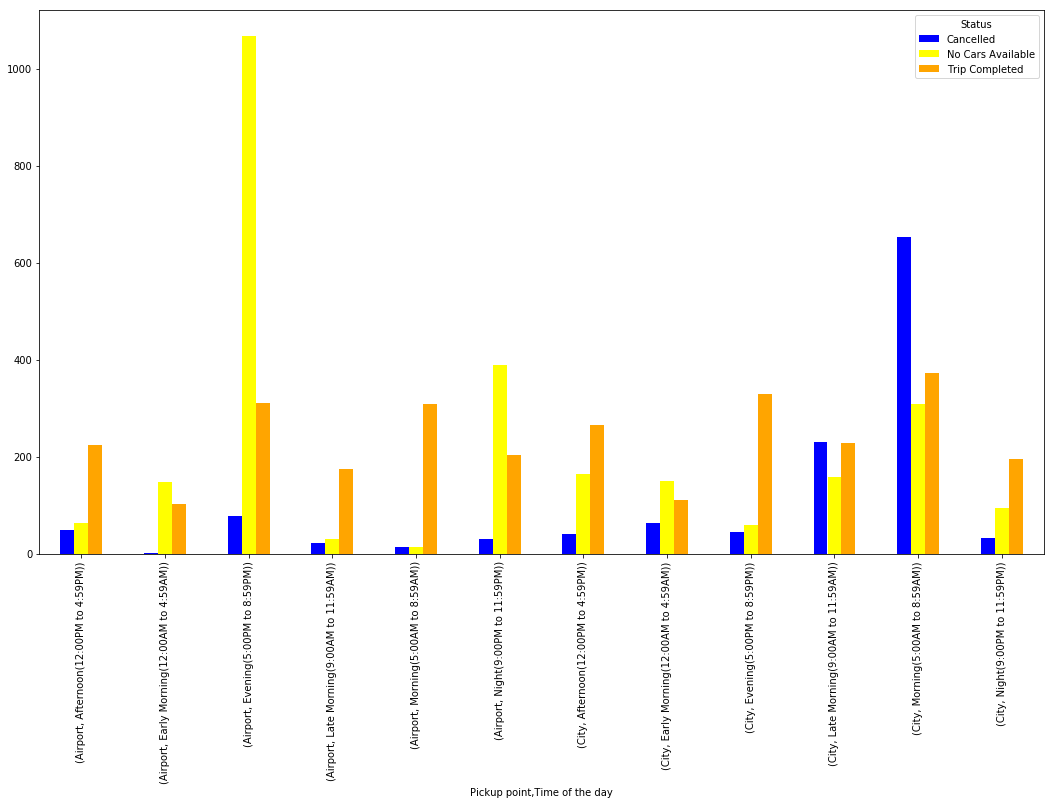

In [35]:
#Plot between Pickup point, time of the day, and Status
df2 = pd.DataFrame(df1.groupby(['Pickup point','Time of the day', 'Status'])['Request id'].count().unstack(fill_value=0))
df2.plot.bar(color=['blue','yellow','orange'])

In [36]:
#Stats for the above graph
df1[['Pickup point','Time of the day','Status']].describe()

,Pickup point,Time of the day,Status
count,6745,6745,6745
unique,2,6,3
top,City,Evening(5:00PM to 8:59PM),Trip Completed
freq,3507,1893,2831


So, here's the thing, we see that from the Airport, we had not many cars available from 5:00 PM to 8:59 PM(might be due to people returning to their home from their workplace, as stated above). Also we see, high no. of trips completed, from the city, during 5 AM to 8:59 AM, but a higher number were cancelled.

Now, let's see what **Pickup point**, **Time of the day** and **Gap** has to tell us....

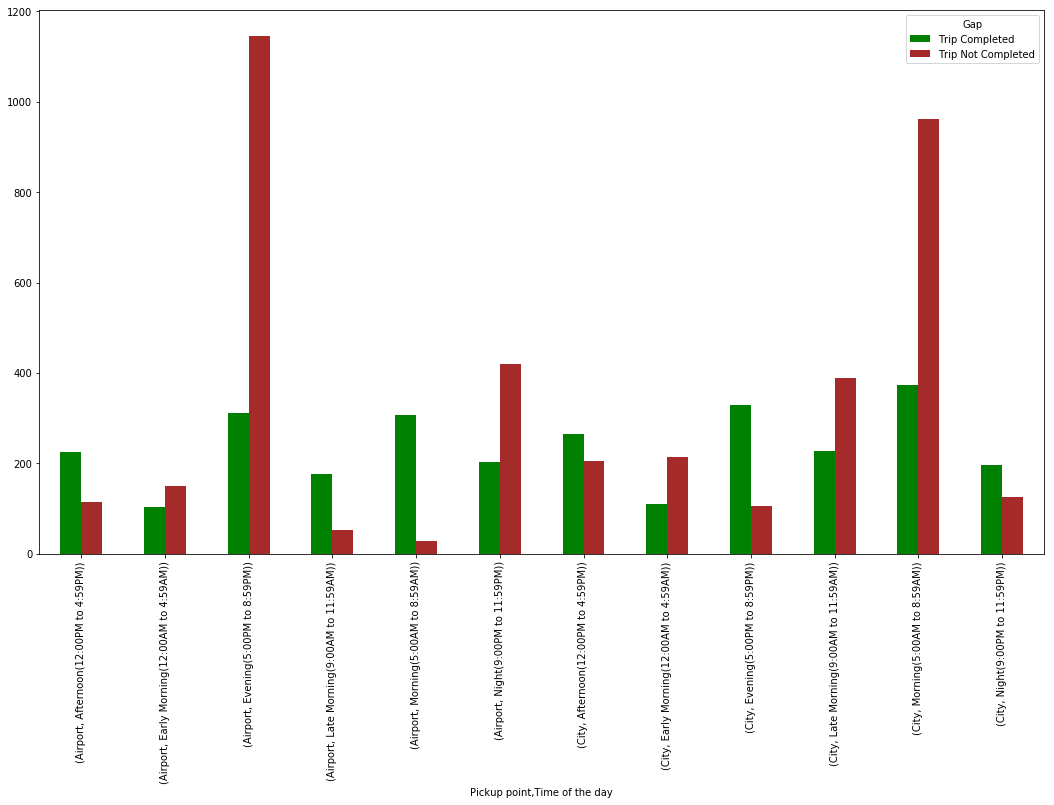

In [37]:
#plot between Pickup point, Time of the day and Gap
totalgap = pd.DataFrame(df1.groupby(['Pickup point','Time of the day','Gap'])['Request id'].count().unstack(fill_value=0))
totalgap.plot.bar(color=['green','brown'])

In [38]:
#Stats for the above graph
df1[['Pickup point','Time of the day','Gap']].describe()

,Pickup point,Time of the day,Gap
count,6745,6745,6745
unique,2,6,2
top,City,Evening(5:00PM to 8:59PM),Trip Not Completed
freq,3507,1893,3914


So, we see that most no. of trips were not completed from airport between 5:00 PM and 8:59 PM. It might be because of the fact that in evening many people travel home  from their work and so, most of the cabs might be booked for that purpose. 

# Final Conclusion

We are going to see a few plots that were important for us to reach the conclusion....

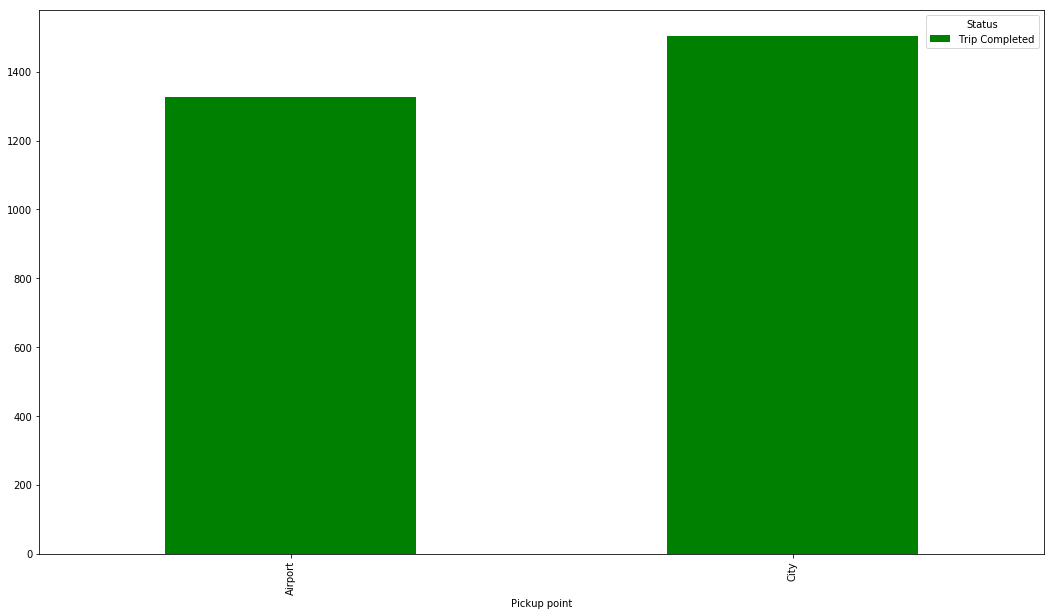

In [39]:
#plot for Trips Completed at city and airport
plt.rcParams['figure.figsize']=(18,10)
pickupgap = pd.DataFrame(df1.loc[(df1['Status']=='Trip Completed')].groupby(['Pickup point','Status'])['Status'].count().unstack(fill_value=0))
pickupgap.plot.bar(color=['green'])

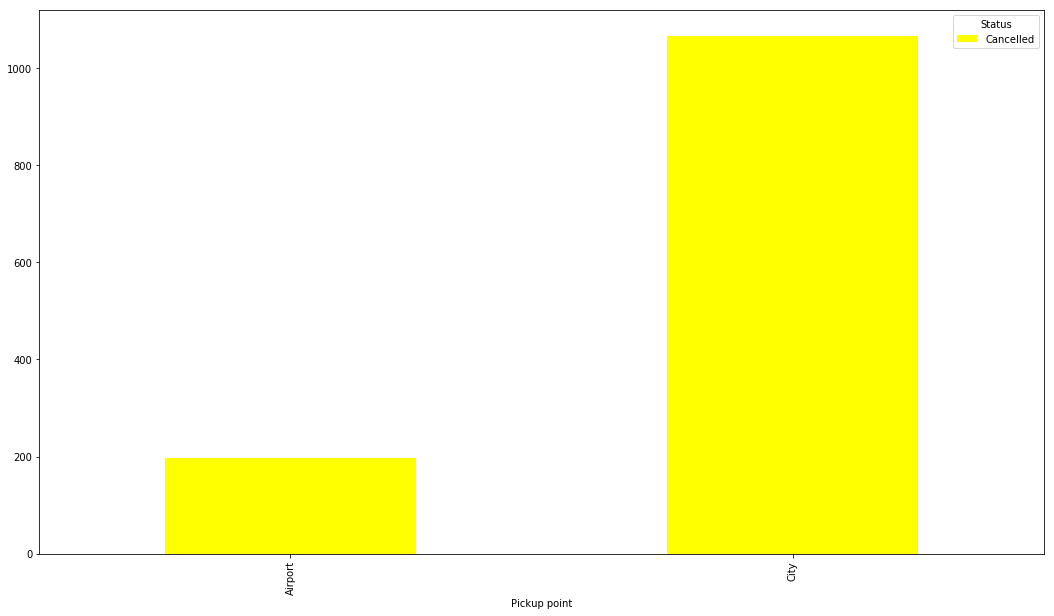

In [40]:
#plot for cancelled rides at city and airport
plt.rcParams['figure.figsize']=(18,10)
pickupgap = pd.DataFrame(df1.loc[(df1['Status']=='Cancelled')].groupby(['Pickup point','Status'])['Status'].count().unstack(fill_value=0))
pickupgap.plot.bar(color=['yellow'])

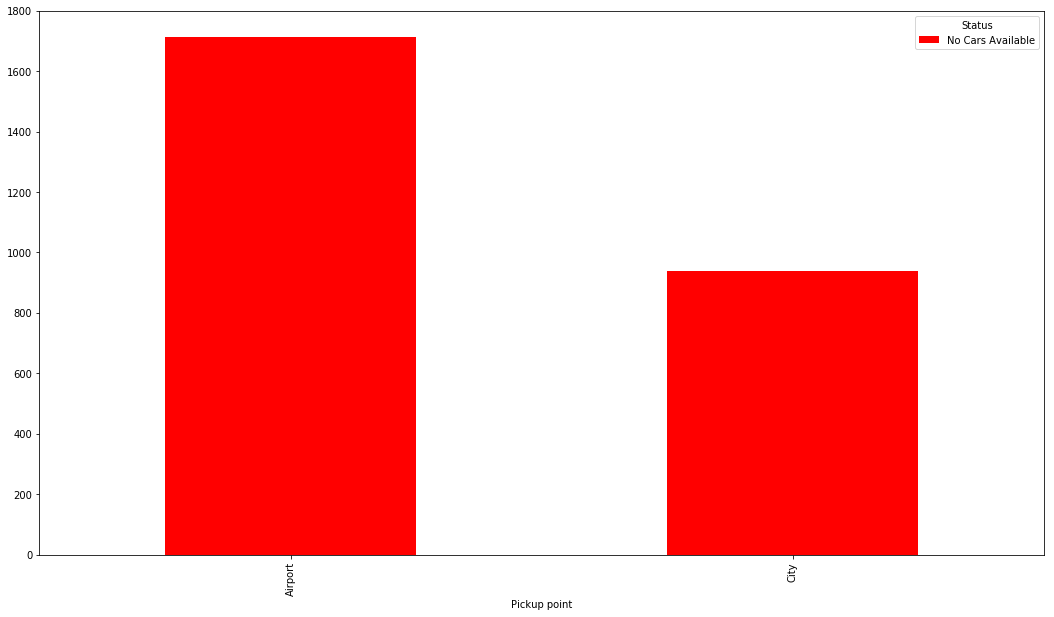

In [41]:
#plot for No Cars Available at city and airport
plt.rcParams['figure.figsize']=(18,10)
pickupgap = pd.DataFrame(df1.loc[(df1['Status']=='No Cars Available')].groupby(['Pickup point','Status'])['Status'].count().unstack(fill_value=0))
pickupgap.plot.bar(color=['red'])

These three plots very well depict the situation where we see that the trips completed from airport is less than what we have from the city, more rides were cancelled at city, and more often no cars were availble at the airports at the time of booking.

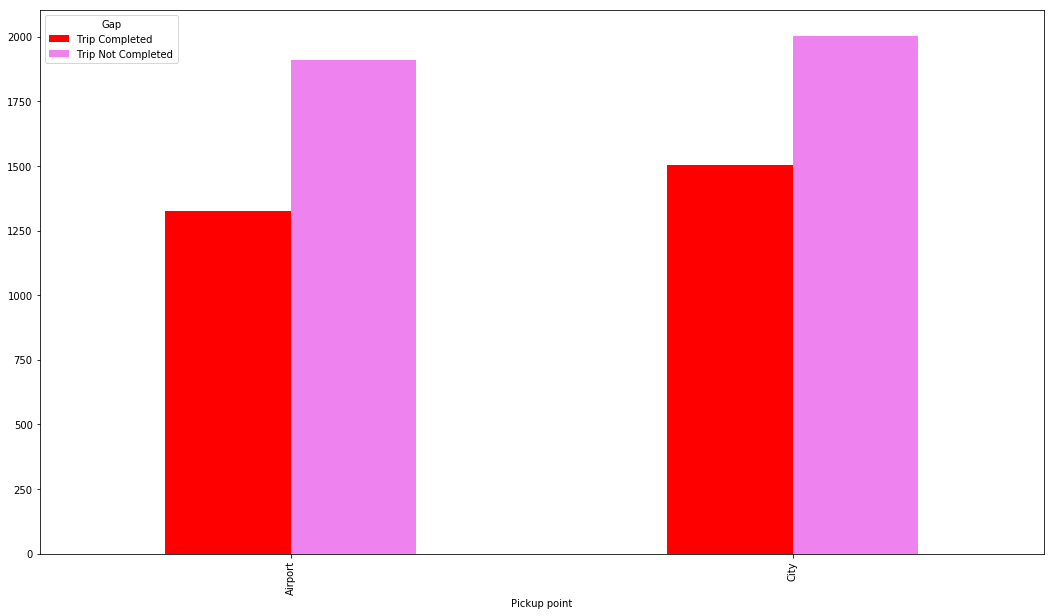

In [42]:
#plot between Pickup point and Gap
plt.rcParams['figure.figsize']=(18,10)
pickupgap = pd.DataFrame(df1.groupby(['Pickup point','Gap'])['Request id'].count().unstack(fill_value=0))
pickupgap.plot.bar(color=['red','violet'])

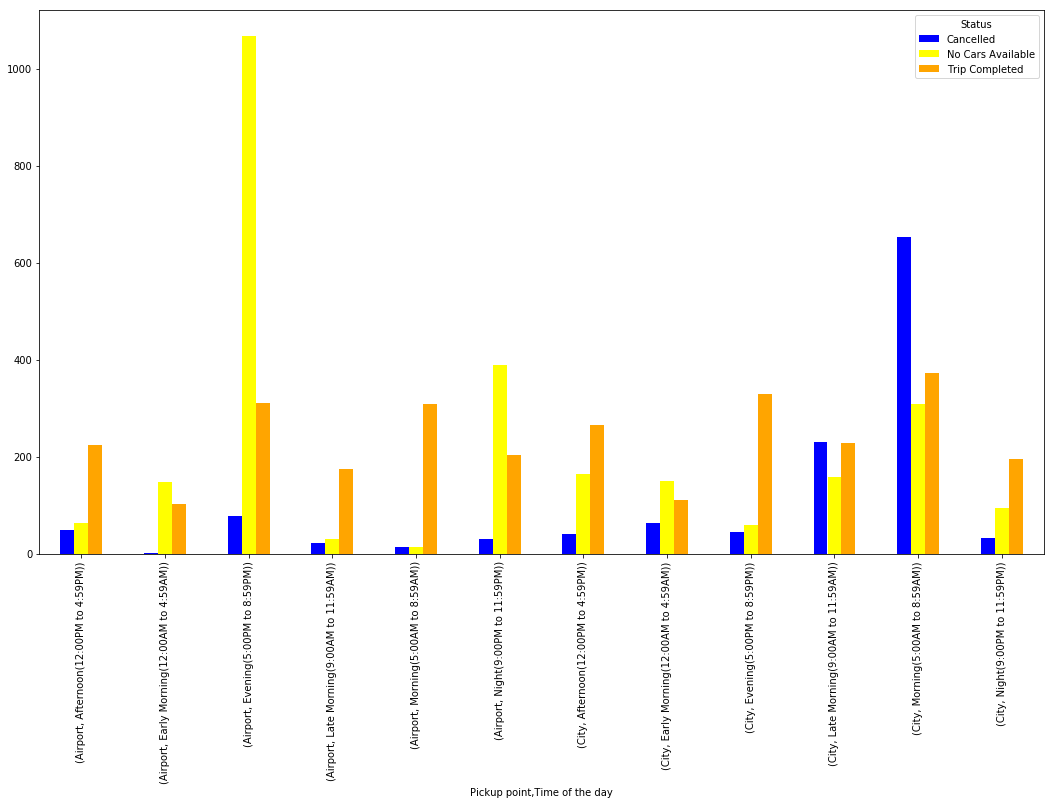

In [43]:
#Plot between Pickup point, time of the day, and Status
df2 = pd.DataFrame(df1.groupby(['Pickup point','Time of the day', 'Status'])['Request id'].count().unstack(fill_value=0))
df2.plot.bar(color=['blue','yellow','orange'])

These two plots shows that there were definitely more rides that were cancelled or for which no cabs were available than rides completed for both from city and airport.The last plot clearly shows that highest no. of cabs were not available at the evening i.e 5:00 PM to 8:59 PM at the airport (which might be due to travelling to and fro from work by people via cabs that most cabs were busy). So, definitely Uber needs a slight more supply of cabs at the airport especially between 5:00 PM and 8:59 PM where it is losing a lot of customers as no cars were available at that moment.
  Uber can assign what no. of cabs are needed in city area and airport area respectively and if needed, it can increase the no. of cabs in it's fleet. Uber can assign the no. of cabs like this : 40% priority for the city to airport rides; 40% priority for the airport to city rides and 20% that can ride for city and airport as needed in case all the designated cabs are totally booked.